# Demonstration: VQE algorithm for excited states

In [15]:
import pennylane as qml
from pennylane import numpy as np

import sys
sys.path.insert(0, '../')
import vqe
import visualization as qplt
import qcnn as qcnn 
import encoder as enc
import general as qmlgen
import losses

from matplotlib import pyplot as plt
##############


In [16]:
Ns = [6,12]
side = 100

path = '../data/vqes/ANNNI/'
pathplots = '../data/plots/'

train_index_line = np.arange(0,2*side-1)
train_index_dots = np.array([0,side-1,2*side-2])

lines = np.concatenate((np.arange(side), np.arange(1,side)*side))
points = np.array([0,side-1,side*side - side])

In [17]:
vqes = []
for N in Ns:
    try:
        filename = 'N'+str(N)+'n'+str(side)
        vqes.append(vqe.load_vqe(path + filename) )
        print('{0} loaded sucessfully'.format(path+filename))
    except:
        print('{0} not found'.format(path+filename))

../data/vqes/ANNNI/N6n100 loaded sucessfully
../data/vqes/ANNNI/N12n100 loaded sucessfully


In [158]:
def getplots(vqeclass, labels = ['a','b','c']):
    """ 1) GET CLASSIFICATION TRAINING ON ALL TRAINING POINTS"""
    if True:
        print('Training on edges')
        qcnnclass = qcnn.qcnn(vqeclass, qcnn.qcnn_circuit, n_outputs = 2)
        qcnnclass.train(.1, 1000, train_index_line, losses.cross_entropy, circuit = True)
        qplt.show_QCNN_classificationANNNI(qcnnclass, hard_thr = False, train_index = lines, label = labels[0], info=True)
        plt.savefig('N'+str(vqeclass.N)+'classification_edges.svg')
    
    """ 2) GET CLASSIFICATION TRAINING ON CORNERS"""
    if True:
        print('Training on corners')
        qcnnclass = qcnn.qcnn(vqeclass, qcnn.qcnn_circuit, n_outputs = 2)
        qcnnclass.train(.1,800, train_index_dots, losses.cross_entropy)
        qplt.show_QCNN_classificationANNNI(qcnnclass, hard_thr = False, train_index = points, label = labels[1], info=False)
        plt.savefig('N'+str(vqeclass.N)+'classification_corners.svg')
    
    if True:
        """ 3) GET COMPRESSIONS"""
        print('Training compression')
        # Define encoder
        encclass  = enc.encoder(vqeclass, enc.encoder_circuit)
        # Train compression of bottom-left state
        encclass.train(0.3, 5000, np.array([0]), circuit = False, plot = False)
        # Display and save
        qplt.show_compression_ANNNI(encclass, 0, label = labels[2], plot3d = False)
        plt.savefig('./'+str(vqeclass.N)+'autoencoder.svg')

In [159]:
import jax

Training on edges
+--- CIRCUIT ---+
0: ──||──||──RY(0.00)─────||──RY(3.00)─╭C──RX(7.00)───RZ(13.00)──RY(14.00)─────||──RY(17.00)─╭C
1: ──||──||──RY(0.00)─╭C──||──RY(4.00)─╰X──RX(8.00)───RZ(13.00)──RY(14.00)─╭C──||──RY(18.00)─╰X
2: ──||──||──RY(1.00)─╰X──||──RY(4.00)─╭C──RX(9.00)───RZ(13.00)──RY(15.00)─╰X──||──RY(18.00)─╭C
3: ──||──||──RY(1.00)─╭C──||──RY(5.00)─╰X──RX(10.00)──RZ(13.00)──RY(15.00)─╭C──||──RY(19.00)─╰X
4: ──||──||──RY(2.00)─╰X──||──RY(5.00)─╭C──RX(11.00)──RZ(13.00)──RY(16.00)─╰X──||──RY(19.00)─╭C
5: ──||──||──RY(2.00)─────||──RY(6.00)─╰X──RX(12.00)──RZ(13.00)──RY(16.00)─────||──RY(20.00)─╰X

───RX(21.00)──||──RZ(27.00)──||─╭C──────────────────────────╭C───────────────────────────||
───RX(22.00)──||──RZ(27.00)──||─╰ControlledOperation(28.00)─╰ControlledOperation(29.00)──||
───RX(23.00)──||──RZ(27.00)──||─╭C──────────────────────────╭C───────────────────────────||
───RX(24.00)──||──RZ(27.00)──||─╰ControlledOperation(30.00)─╰ControlledOperation(31.00)──||
───RX(25.00)──||──R

Cost: 0.09516531974077225: 100%|████████████| 1000/1000 [00:18<00:00, 52.85it/s]


Training on corners


Cost: 0.036742858588695526: 100%|█████████████| 800/800 [00:20<00:00, 38.69it/s]


Training compression


Cost: 4.589557647705078e-06: 100%|█████████| 5000/5000 [00:16<00:00, 305.00it/s]


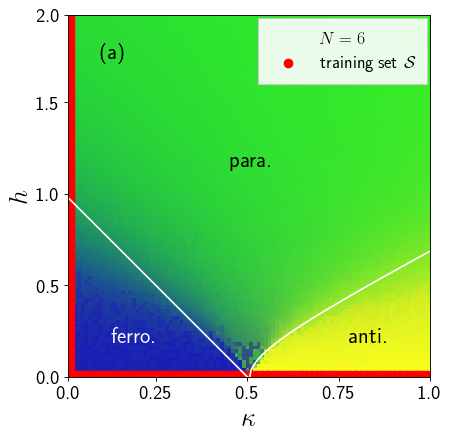

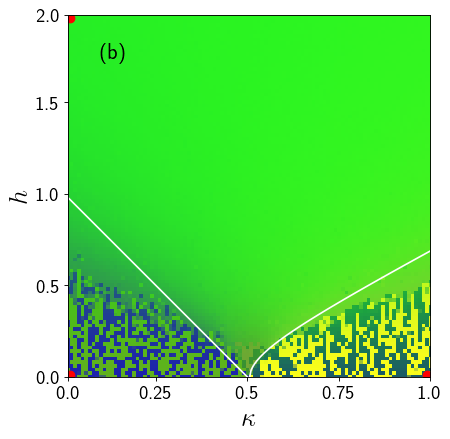

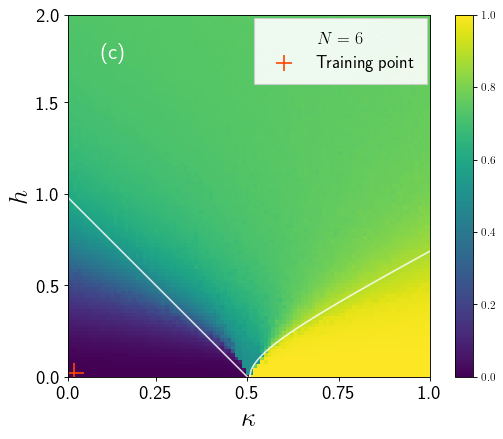

In [160]:
getplots(vqes[0])

In [ ]:
getplots(vqes[1], labels = ['d','e','f'])